In [ ]:
import os
os.environ['TEJAPI_KEY'] = "your key" 
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
from zipline.sources.TEJ_Api_Data import get_Benchmark_Return

In [2]:
start = '2021-01-01'
end = '2023-12-31'

os.environ['ticker'] = 'IR0001 2317 2327 2330 2353 2357 2382'
os.environ['mdate'] = start+' '+end
!zipline ingest -b tquant


Merging daily equity files:
Currently used TEJ API key call quota 8/100000 (0.01%)
Currently used TEJ API key data quota 12688/10000000 (0.13%)


[2024-05-08 02:18:52.238854] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-05-08 02:18:56.900453] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [3]:
from zipline.data import bundles
from zipline.sources.TEJ_Api_Data import get_Benchmark_Return
from zipline.pipeline.mixins import SingleInputMixin
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.factors import CustomFactor
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.utils.math_utils import nanmax, nanmin

class Wmsr(CustomFactor):
    inputs = [TWEquityPricing.close, TWEquityPricing.high, TWEquityPricing.low]
    window_length = 100
    
    def compute(self, today, assets, out, close, high, low):
        highest_highs = nanmax(high, axis=0)
        lowest_lows = nanmin(low, axis=0)
        williams_index = ((highest_highs - close[-1]) / (highest_highs - lowest_lows)) * 100 * -1
        
        out[:] = williams_index

In [4]:
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')
bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():
    wmsr = Wmsr()
    curr_price = TWEquityPricing.close.latest
    
    return Pipeline(
        columns = {
            'curr_price':curr_price,
            'Williams_index' : wmsr,
        },
        screen = ~StaticAssets([benchmark_asset])
    )
my_pipeline = run_pipeline(make_pipeline(),start_dt, end_dt)
my_pipeline.tail(20)

curr_price  Williams_index
2023-12-26 00:00:00+00:00 Equity(4 [2357])       471.5       -5.067568
                          Equity(5 [2382])       215.5      -70.744681
2023-12-27 00:00:00+00:00 Equity(0 [2317])       104.0      -45.945946
                          Equity(1 [2327])       600.0      -17.616580
                          Equity(2 [2330])       586.0       -2.677991
                          Equity(3 [2353])        50.6       -0.000000
                          Equity(4 [2357])       472.0       -4.729730
                          Equity(5 [2382])       216.0      -70.212766
2023-12-28 00:00:00+00:00 Equity(0 [2317])       103.5      -48.648649
                          Equity(1 [2327])       601.0      -17.098446
                          Equity(2 [2330])       592.0       -0.000000
                          Equity(3 [2353])        54.2       -2.764977
                          Equity(4 [2357])       491.5       -2.727273
                          Equity(5 [2382])       215.5      -70.744681
2023-12-29 00:00:00+00:00 Equity(0 [2317])       104.0      -42.857143
                          Equity(1 [2327])       597.0      -19.170984
                          Equity(2 [2330])       593.0       -0.000000
                          Equity(3 [2353])        54.0       -9.913793
                          Equity(4 [2357])       492.0       -5.847953
                          Equity(5 [2382])       217.0      -69.148936

In [5]:
from zipline.finance import slippage, commission
from zipline.api import *
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output, record

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    attach_pipeline(make_pipeline(), 'mystrats')
    set_benchmark(symbol('IR0001'))
    

In [6]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')
    
    for i in out_dir.index:
        curr_price = out_dir.loc[i, 'curr_price']
        w_value = out_dir.loc[i, 'Williams_index']
        stock_position = context.portfolio.positions[i].amount
        cash_position = context.portfolio.cash

        if stock_position == 0 and cash_position >= curr_price * 1000:
            if w_value <= -80:
                order(i, 1000)
        elif stock_position > 0:
            if w_value <= -80 and cash_position >= curr_price * 1000:
                order(i, 1000)
                
            elif w_value >= -20:
                order_target(i, 0)

In [7]:
from zipline import run_algorithm

start_date = pd.Timestamp('2021-01-01',tz='utc')
end_date = pd.Timestamp('2023-12-31',tz='utc')

results = run_algorithm(start = start_date,  
                        end = end_date,
                        initialize = initialize,                      
                        capital_base = 1e7,                      
                        handle_data = handle_data,
                        data_frequency = 'daily',
                        bundle = 'tquant'
                        )
results

,period_open,period_close,returns,gross_leverage,net_leverage,long_exposure,short_value,starting_value,orders,long_value,...,trading_days,treasury_period_return,max_drawdown,sharpe,sortino,alpha,beta,benchmark_period_return,excess_return,benchmark_volatility
2021-01-04 13:30:00+08:00,2021-01-04 09:01:00+08:00,2021-01-04 13:30:00+08:00,0.000000,0.000000,0.000000,0.0,0.0,0.0,[],0.0,...,1,0.0,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2021-01-05 13:30:00+08:00,2021-01-05 09:01:00+08:00,2021-01-05 13:30:00+08:00,0.000000,0.000000,0.000000,0.0,0.0,0.0,[],0.0,...,2,0.0,0.000000,NaN,NaN,NaN,NaN,0.006576,-0.006576,NaN
2021-01-06 13:30:00+08:00,2021-01-06 09:01:00+08:00,2021-01-06 13:30:00+08:00,0.000000,0.000000,0.000000,0.0,0.0,0.0,[],0.0,...,3,0.0,0.000000,NaN,NaN,0.000000,0.000000,0.005442,-0.005442,0.086463
2021-01-07 13:30:00+08:00,2021-01-07 09:01:00+08:00,2021-01-07 13:30:00+08:00,0.000000,0.000000,0.000000,0.0,0.0,0.0,"[{'id': '3b6dfbb322c345b891ad7ee77c4a2a58', 'd...",0.0,...,4,0.0,0.000000,NaN,NaN,0.000000,0.000000,0.020935,-0.020935,0.131343
2021-01-08 13:30:00+08:00,2021-01-08 09:01:00+08:00,2021-01-08 13:30:00+08:00,-0.000004,0.002490,0.002490,24900.0,0.0,0.0,"[{'id': '3b6dfbb322c345b891ad7ee77c4a2a58', 'd...",24900.0,...,5,0.0,-0.000004,-7.099296,-7.099296,0.000067,-0.000125,0.037708,-0.037711,0.130990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,0.000403,0.287255,0.287255,3923000.0,0.0,3917500.0,[],3923000.0,...,725,0.0,-0.346384,0.684176,1.025048,0.053734,0.658626,0.318751,0.046934,0.168702
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,0.000952,0.287933,0.287933,3936000.0,0.0,3923000.0,[],3936000.0,...,726,0.0,-0.346384,0.685515,1.027054,0.052050,0.658166,0.329760,0.037225,0.168650
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,-0.000951,0.287255,0.287255,3923000.0,0.0,3936000.0,[],3923000.0,...,727,0.0,-0.346384,0.683229,1.023629,0.049809,0.657592,0.340230,0.025455,0.168590
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,0.001757,0.288506,0.288506,3947000.0,0.0,3923000.0,[],3947000.0,...,728,0.0,-0.346384,0.686092,1.027925,0.050125,0.657598,0.341643,0.026441,0.168474


Start date,2021-01-04
End date,2023-12-29
Total months,34
,Backtest
Annual return,11.696%
Cumulative returns,37.708%
Annual volatility,18.221%
Sharpe ratio,0.70
Calmar ratio,0.34
Stability,0.26
Max drawdown,-34.638%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.64,2022-03-30,2022-10-25,NaT,NaN
1,4.90,2021-09-27,2021-10-01,2021-10-13,12
2,4.89,2021-05-07,2021-05-13,2021-05-25,13
3,3.23,2021-05-31,2021-06-07,2021-06-15,11
4,2.84,2021-07-07,2021-08-19,2021-09-16,52


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.05%,-6.42%,6.31%


Top 10 long positions of all time,max
sid,
2327,98.97%
2357,75.61%
2330,47.57%
2317,42.43%
2382,19.68%
2353,6.65%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2327,98.97%
2357,75.61%
2330,47.57%
2317,42.43%
2382,19.68%
2353,6.65%


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


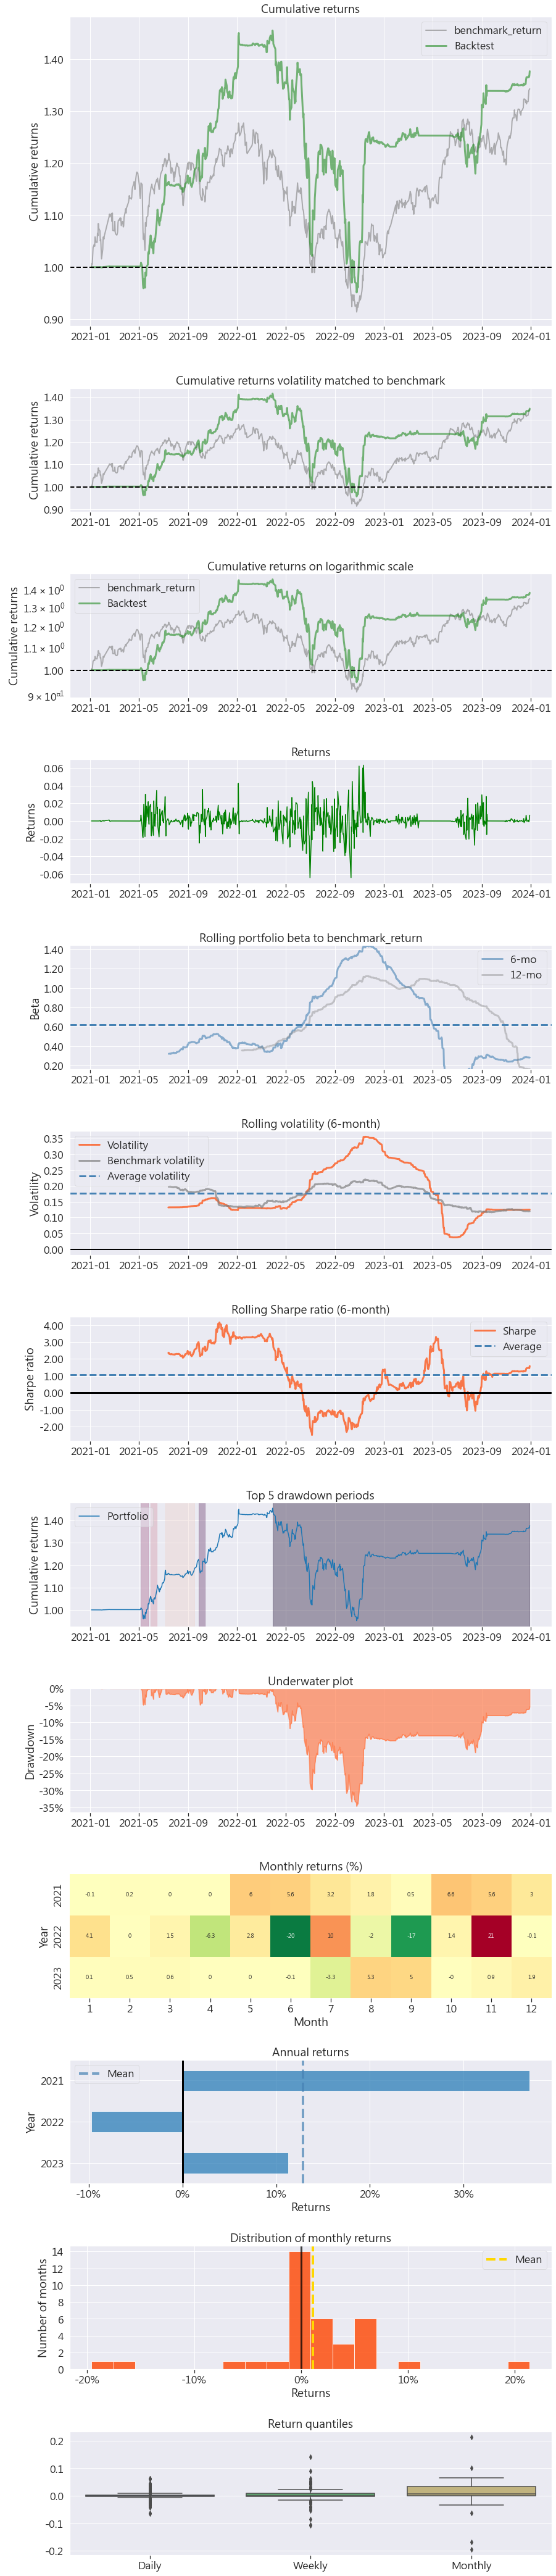

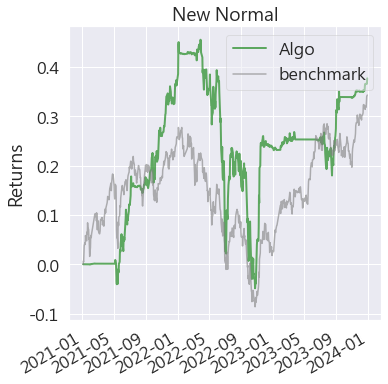

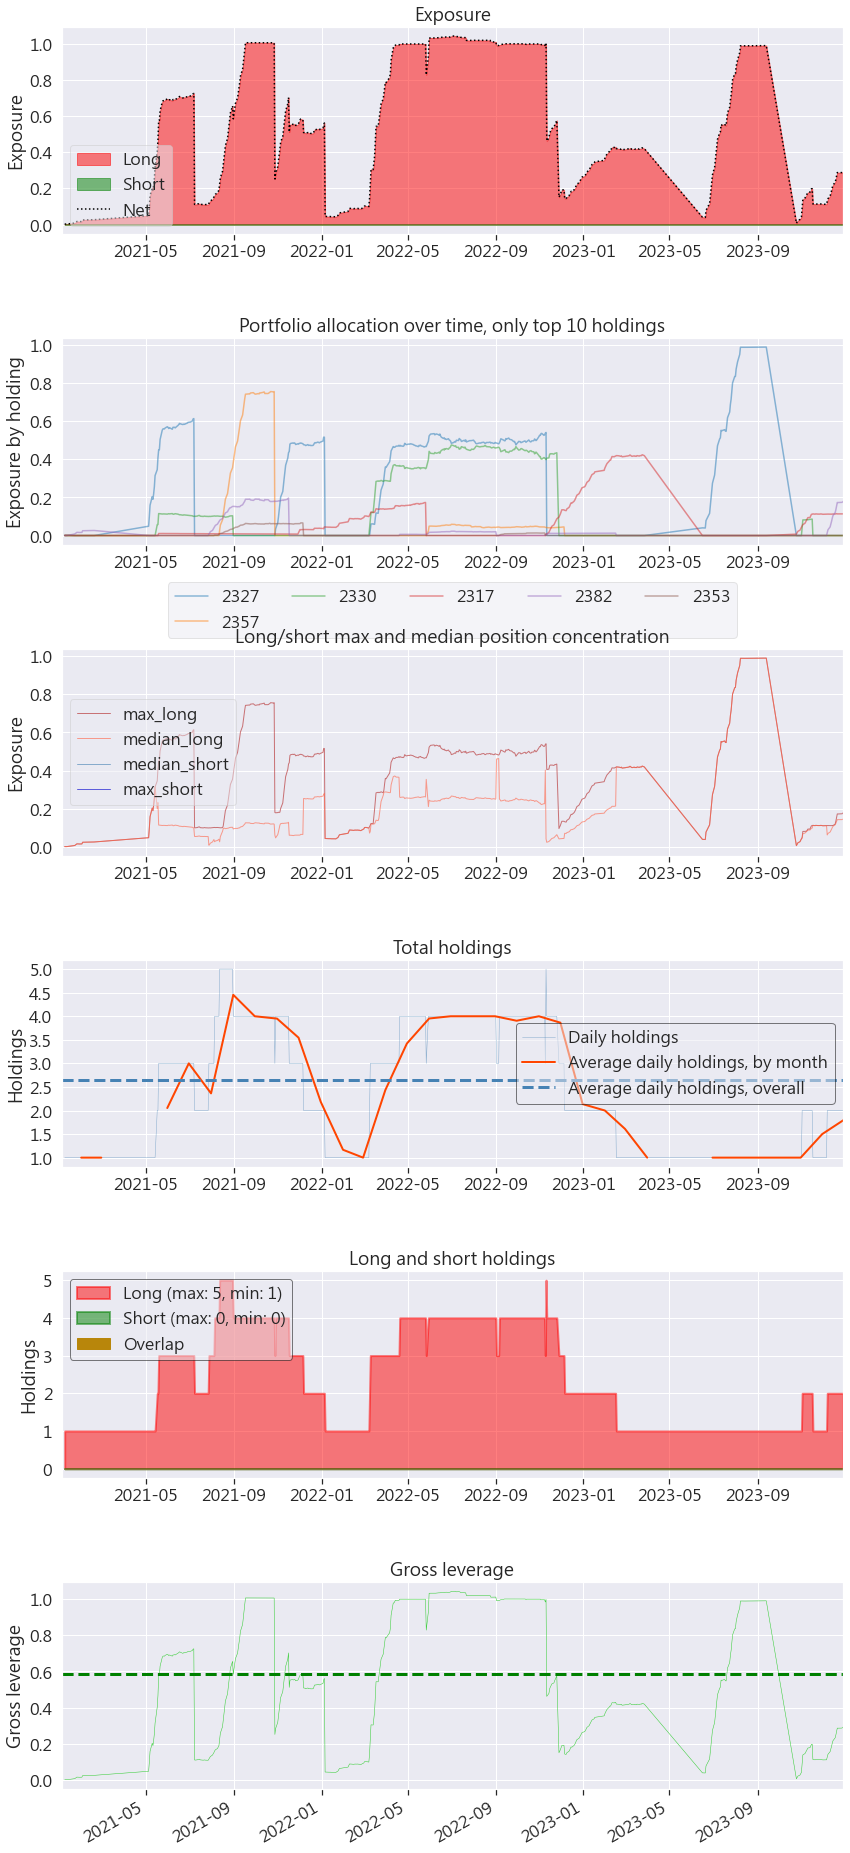

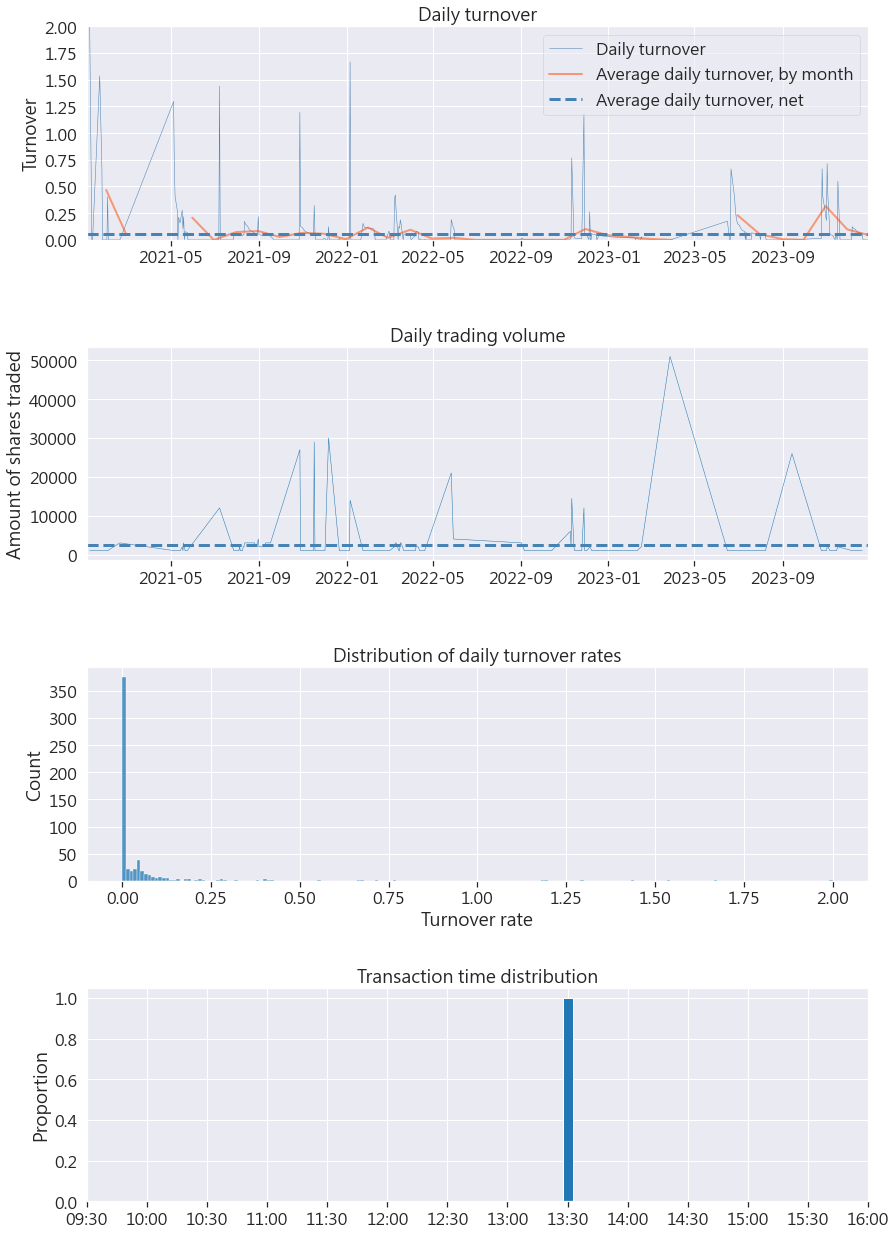

In [8]:
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions,
                          benchmark_rets = benchmark_rets,
                          round_trips=False)